# Анализ таблиц JDWH - Прод vs Тест

In [1]:
import pandas as pd
import numpy as np 
from datetime import datetime

In [2]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 500)

## 1. Загрузка и первичное преобразование данных
(Это подготовка. Отчеты идут с раздела 2.)

### Прод

In [3]:
prod = pd.read_csv('./data/tables_sizes_prod_12122020.csv')

Добавим столбец base_name - базовое имя таблиц (без учета партиций).
Преобразуем last_analyze в дату-время.

In [4]:
prod['base_name'] = prod['table_name'].apply(lambda x: x.split('_1_prt_')[0])
prod['last_analyze'] = prod.last_analyze.apply(lambda x: None if pd.isna(x) else datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [5]:
prod.head(5)

,table_schema,table_name,table_size,table_size_p,indexes_size,indexes_size_p,total_size,total_size_p,row_count_approx,last_analyze,row_count_exact,base_name
0,dwh_stage,s01_t_trndtl_1_prt_other,208488562688,194 GB,51620184064,48 GB,260108746752,242 GB,1121557503,2020-10-08 13:18:32,1122620693,s01_t_trndtl
1,dwh_stage,s01_t_operjrn,74459756328,69 GB,180960886784,169 GB,255420643112,238 GB,922357000,2020-10-08 12:41:48,958449833,s01_t_operjrn
2,dwh_dds,acc_account_balance,115628942832,108 GB,9779740672,9327 MB,125408683504,117 GB,725052276,2020-10-05 14:53:31,243607804,acc_account_balance
3,dwh_stage,s01_t_trndtl_tmp_1_prt_deb,59084767232,55 GB,17744199680,17 GB,76828966912,72 GB,561938533,2020-12-10 14:21:43,562674047,s01_t_trndtl_tmp
4,dwh_stage,s01_t_trndtl_tmp_1_prt_cred,56182702080,52 GB,16857038848,16 GB,73039740928,68 GB,534101903,2020-12-10 14:21:49,534830816,s01_t_trndtl_tmp


Сгруппируем данные по table_schema, base_name (группировка по партициям)

In [6]:
prod_gr = prod.groupby(['table_schema', 'base_name']).agg(
    table_size = pd.NamedAgg(column = 'table_size', aggfunc = 'sum'),
    indexes_size = pd.NamedAgg(column = 'indexes_size', aggfunc = 'sum'),
    total_size = pd.NamedAgg(column = 'total_size', aggfunc = 'sum'),
    row_count_approx = pd.NamedAgg(column = 'row_count_approx', aggfunc = 'sum'),
    last_analyze_min = pd.NamedAgg(column = 'last_analyze', aggfunc = 'min'),
    last_analyze_max = pd.NamedAgg(column = 'last_analyze', aggfunc = 'max'),
    row_count_exact = pd.NamedAgg(column = 'row_count_exact', aggfunc = 'max'),
)

In [7]:
prod_gr.reset_index(level=['table_schema', 'base_name'], inplace=True)
prod_gr.head(3)

,table_schema,base_name,table_size,indexes_size,total_size,row_count_approx,last_analyze_min,last_analyze_max,row_count_exact
0,dwh_bckp,amara_corr_overdues,0,294912,294912,0,NaT,NaT,0
1,dwh_bckp,amara_rating_fitch,262144,557056,819200,0,NaT,NaT,693
2,dwh_bckp,amara_rating_fitch_bckp,557056,0,557056,10,2020-08-26 16:06:11,2020-08-26 16:06:11,21


In [8]:
prod_gr[(prod_gr.table_schema=='dwh_stage') & (prod_gr.base_name=='s01_t_trndtl')]

,table_schema,base_name,table_size,indexes_size,total_size,row_count_approx,last_analyze_min,last_analyze_max,row_count_exact
522,dwh_stage,s01_t_trndtl,380200091648,93152378880,473352470528,1664699176,2020-10-08 13:13:26,2020-10-08 17:46:44,1719055182


### Тест

In [9]:
test = pd.read_csv('./data/tables_sizes_test_12122020.csv')

Добавим столбец base_name - базовое имя таблиц (без учета партиций). Преобразуем last_analyze в дату-время.

In [10]:
test['base_name'] = test['table_name'].apply(lambda x: x.split('_1_prt_')[0])
test['last_analyze'] = test.last_analyze.apply(lambda x: None if pd.isna(x) else datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [11]:
test.head(3)

,table_schema,table_name,table_size,table_size_p,indexes_size,indexes_size_p,total_size,total_size_p,row_count_approx,last_analyze,row_count_exact,base_name
0,dwh_stage,s02_opt_vw_balance_dafb,159287738368,148 GB,173473792,165 MB,159461212160,149 GB,1462717913,2020-12-12 17:55:16,1462862288,s02_opt_vw_balance_dafb
1,dwh_stage,s09_q_row,79593897984,74 GB,14041481216,13 GB,93635379200,87 GB,630123226,2020-12-12 18:02:07,630183557,s09_q_row
2,dwh_polygon,dm_z10_bck_170920,80207675392,75 GB,0,0 bytes,80207675392,75 GB,0,NaT,111177183,dm_z10_bck_170920


Сгруппируем данные по table_schema, base_name (группировка по партициям)

In [12]:
test_gr = test.groupby(['table_schema', 'base_name']).agg(
    table_size = pd.NamedAgg(column = 'table_size', aggfunc = 'sum'),
    indexes_size = pd.NamedAgg(column = 'indexes_size', aggfunc = 'sum'),
    total_size = pd.NamedAgg(column = 'total_size', aggfunc = 'sum'),
    row_count_approx = pd.NamedAgg(column = 'row_count_approx', aggfunc = 'sum'),
    last_analyze_min = pd.NamedAgg(column = 'last_analyze', aggfunc = 'min'),
    last_analyze_max = pd.NamedAgg(column = 'last_analyze', aggfunc = 'max'),
    row_count_exact = pd.NamedAgg(column = 'row_count_exact', aggfunc = 'max'),
)

In [13]:
test_gr.reset_index(level=['table_schema', 'base_name'], inplace=True)
test_gr.head(3)

,table_schema,base_name,table_size,indexes_size,total_size,row_count_approx,last_analyze_min,last_analyze_max,row_count_exact
0,dwh_bckp,amara_daughter_companies_bckp,524288,0,524288,11,2020-11-26 16:09:28,2020-11-26 16:09:28,13
1,dwh_bckp,amara_rating_fitch,262144,557056,819200,0,NaT,NaT,42
2,dwh_bckp,amara_rating_fitch_bckp,557056,0,557056,0,NaT,NaT,42


Добавим столбцы instance и full_table_name

In [14]:
prod['instance'] = 'prod'
prod_gr['instance'] = 'prod'
test['instance'] = 'test'
test_gr['instance'] = 'test'

prod['full_table_name'] = prod.table_schema + '.' + prod.table_name
prod_gr['full_table_name'] = prod_gr.table_schema + '.' + prod_gr.base_name
test['full_table_name'] = test.table_schema + '.' + test.table_name
test_gr['full_table_name'] = test_gr.table_schema + '.' + test_gr.base_name

In [15]:
test_gr.head(1)

,table_schema,base_name,table_size,indexes_size,total_size,row_count_approx,last_analyze_min,last_analyze_max,row_count_exact,instance,full_table_name
0,dwh_bckp,amara_daughter_companies_bckp,524288,0,524288,11,2020-11-26 16:09:28,2020-11-26 16:09:28,13,test,dwh_bckp.amara_daughter_companies_bckp


In [16]:
prod.head(1)

,table_schema,table_name,table_size,table_size_p,indexes_size,indexes_size_p,total_size,total_size_p,row_count_approx,last_analyze,row_count_exact,base_name,instance,full_table_name
0,dwh_stage,s01_t_trndtl_1_prt_other,208488562688,194 GB,51620184064,48 GB,260108746752,242 GB,1121557503,2020-10-08 13:18:32,1122620693,s01_t_trndtl,prod,dwh_stage.s01_t_trndtl_1_prt_other


Добавим поля с размерами в удобочитаемом виде

In [17]:
def transform_size(sz):
    if sz >= (1024*1024*1024):
        return str(round(sz/(1024*1024*1024))) + ' GB'
    elif sz >= (1024*1024):
        return str(round(sz/(1024*1024))) + ' MB'
    elif sz >= 1024:
        return str(round(sz/1024)) + ' KB'
    else:
        return str(sz) + ' byte'

In [18]:
test_gr['table_size_p'] = test_gr['table_size'].apply(lambda x: transform_size(x))
test_gr['indexes_size_p'] = test_gr['indexes_size'].apply(lambda x: transform_size(x))
test_gr['total_size_p'] = test_gr['total_size'].apply(lambda x: transform_size(x))


prod_gr['table_size_p'] = prod_gr['table_size'].apply(lambda x: transform_size(x))
prod_gr['indexes_size_p'] = prod_gr['indexes_size'].apply(lambda x: transform_size(x))
prod_gr['total_size_p'] = prod_gr['total_size'].apply(lambda x: transform_size(x))

In [20]:
test_gr.head(1)

,table_schema,base_name,table_size,indexes_size,total_size,row_count_approx,last_analyze_min,last_analyze_max,row_count_exact,instance,full_table_name,table_size_p,indexes_size_p,total_size_p
0,dwh_bckp,amara_daughter_companies_bckp,524288,0,524288,11,2020-11-26 16:09:28,2020-11-26 16:09:28,13,test,dwh_bckp.amara_daughter_companies_bckp,512 KB,0 byte,512 KB


## 2. Количество таблиц по схемам

### Прод

Все

In [21]:
prod.table_schema.value_counts()

pg_bitmapindex    2023
dwh_stage         1865
dwh_dm             895
dwh_bckp           763
dwh_dds            501
dwh_polygon        136
dwh_draft           25
dwh_dq              10
dwh_private          4
Name: table_schema, dtype: int64

Matplotlib is building the font cache; this may take a moment.


<AxesSubplot:title={'center':'Prod: Tables count by schemas'}>

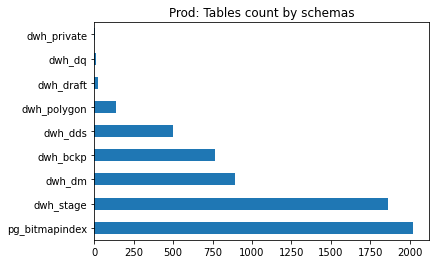

In [22]:
prod.table_schema.value_counts().plot(kind = 'barh', title='Prod: Tables count by schemas')

С группировкой по партициям

In [23]:
prod_gr.table_schema.value_counts()

pg_bitmapindex    2023
dwh_stage          292
dwh_dds            123
dwh_polygon        103
dwh_bckp            29
dwh_draft           25
dwh_dm              22
dwh_dq              10
dwh_private          4
Name: table_schema, dtype: int64

### ТЕСТ

Все

In [24]:
test.table_schema.value_counts()

pg_bitmapindex    4042
dwh_stage         2264
dwh_dm            2219
dwh_bckp           768
dwh_dds            658
dwh_dq             377
dwh_polygon        185
dwh_rb              37
dwh_draft           35
Name: table_schema, dtype: int64

С группировкой по партициям

In [25]:
test_gr.table_schema.value_counts()

pg_bitmapindex    4042
dwh_stage          300
dwh_polygon        185
dwh_dds            123
dwh_rb              37
dwh_draft           35
dwh_bckp            34
dwh_dm              30
dwh_dq              10
Name: table_schema, dtype: int64

## 3. Top 15 таблиц по размерам и количеству строк

### Прод

По размеру таблицы

In [26]:
prod_total_size = prod.nlargest(15,'total_size')[['full_table_name', 'table_size_p', 'indexes_size_p', 'total_size_p', 'row_count_exact']]
prod_total_size

,full_table_name,table_size_p,indexes_size_p,total_size_p,row_count_exact
0,dwh_stage.s01_t_trndtl_1_prt_other,194 GB,48 GB,242 GB,1122620693
1,dwh_stage.s01_t_operjrn,69 GB,169 GB,238 GB,958449833
2,dwh_dds.acc_account_balance,108 GB,9327 MB,117 GB,243607804
3,dwh_stage.s01_t_trndtl_tmp_1_prt_deb,55 GB,17 GB,72 GB,562674047
4,dwh_stage.s01_t_trndtl_tmp_1_prt_cred,52 GB,16 GB,68 GB,534830816
5,dwh_stage.s02_opt_account,68 GB,0 bytes,68 GB,1133629530
6,dwh_stage.s02_opt_vw_balance_dafb,45 GB,43 MB,45 GB,439633296
7,dwh_polygon.s02_opt_vw_balance_dafb_tuleng,41 GB,39 MB,41 GB,405916018
8,dwh_dds.acc_doc_payment,35 GB,1017 MB,36 GB,15093349
9,dwh_dm.dm_z10_1_prt_94_2020_10_13,24 GB,1033 MB,25 GB,7581848


По размеру таблицы. Сгруппированно по партициям

In [27]:
prod_gr_total_size = prod_gr.nlargest(15,'total_size')[['full_table_name', 'table_size_p', 'indexes_size_p', 'total_size_p', 'row_count_exact']]
prod_gr_total_size

,full_table_name,table_size_p,indexes_size_p,total_size_p,row_count_exact
522,dwh_stage.s01_t_trndtl,354 GB,87 GB,441 GB,1719055182
500,dwh_stage.s01_t_operjrn,69 GB,169 GB,238 GB,958449833
164,dwh_dm.dm_z10,223 GB,10 GB,233 GB,106203713
483,dwh_stage.s01_t_bal,162 GB,54 GB,215 GB,1811349736
523,dwh_stage.s01_t_trndtl_tmp,107 GB,32 GB,140 GB,1097504863
29,dwh_dds.acc_account_balance,108 GB,9 GB,117 GB,243607804
26,dwh_bckp.s01_led_acc_det_bkp,60 GB,50 GB,110 GB,469350785
561,dwh_stage.s02_opt_account,68 GB,0 byte,68 GB,1133629530
568,dwh_stage.s02_opt_vw_balance_dafb,45 GB,42 MB,45 GB,439633296
302,dwh_polygon.s02_opt_vw_balance_dafb_tuleng,41 GB,39 MB,41 GB,405916018


По количеству строк

In [28]:
prod_row_count = prod.nlargest(15,'row_count_exact')[['full_table_name', 'table_size_p', 'indexes_size_p', 'total_size_p', 'row_count_exact']]
prod_row_count

,full_table_name,table_size_p,indexes_size_p,total_size_p,row_count_exact
5846,dwh_stage.s01_t_bal,0 bytes,288 kB,288 kB,1811349736
4314,dwh_stage.s01_t_bal_1_prt_no_flzo,0 bytes,288 kB,288 kB,1767310882
1468,dwh_stage.s01_t_trndtl,0 bytes,1728 kB,1728 kB,1719055182
5,dwh_stage.s02_opt_account,68 GB,0 bytes,68 GB,1133629530
0,dwh_stage.s01_t_trndtl_1_prt_other,194 GB,48 GB,242 GB,1122620693
6058,dwh_stage.s01_t_trndtl_tmp,0 bytes,288 kB,288 kB,1097504863
1,dwh_stage.s01_t_operjrn,69 GB,169 GB,238 GB,958449833
3,dwh_stage.s01_t_trndtl_tmp_1_prt_deb,55 GB,17 GB,72 GB,562674047
4,dwh_stage.s01_t_trndtl_tmp_1_prt_cred,52 GB,16 GB,68 GB,534830816
1602,dwh_bckp.s01_led_acc_det_bkp,0 bytes,1440 kB,1440 kB,469350785


По количеству строк. Сгруппированно по партициям

In [29]:
prod_gr_row_count = prod_gr.nlargest(15,'row_count_exact')[['full_table_name', 'table_size_p', 'indexes_size_p', 'total_size_p', 'row_count_exact']]
prod_gr_row_count

,full_table_name,table_size_p,indexes_size_p,total_size_p,row_count_exact
483,dwh_stage.s01_t_bal,162 GB,54 GB,215 GB,1811349736
522,dwh_stage.s01_t_trndtl,354 GB,87 GB,441 GB,1719055182
561,dwh_stage.s02_opt_account,68 GB,0 byte,68 GB,1133629530
523,dwh_stage.s01_t_trndtl_tmp,107 GB,32 GB,140 GB,1097504863
500,dwh_stage.s01_t_operjrn,69 GB,169 GB,238 GB,958449833
26,dwh_bckp.s01_led_acc_det_bkp,60 GB,50 GB,110 GB,469350785
568,dwh_stage.s02_opt_vw_balance_dafb,45 GB,42 MB,45 GB,439633296
302,dwh_polygon.s02_opt_vw_balance_dafb_tuleng,41 GB,39 MB,41 GB,405916018
516,dwh_stage.s01_t_procmem_old,17 GB,0 byte,17 GB,267585548
29,dwh_dds.acc_account_balance,108 GB,9 GB,117 GB,243607804


### Тест

По размеру таблицы

In [30]:
test_total_size = test.nlargest(15,'total_size')[['full_table_name', 'table_size_p', 'indexes_size_p', 'total_size_p', 'row_count_exact']]
test_total_size

,full_table_name,table_size_p,indexes_size_p,total_size_p,row_count_exact
0,dwh_stage.s02_opt_vw_balance_dafb,148 GB,165 MB,149 GB,1462862288
1,dwh_stage.s09_q_row,74 GB,13 GB,87 GB,630183557
2,dwh_polygon.dm_z10_bck_170920,75 GB,0 bytes,75 GB,111177183
3,dwh_polygon.dm_z10_bck_07122020,73 GB,0 bytes,73 GB,93822639
4,dwh_stage.s02_opt_account,65 GB,0 bytes,65 GB,1080993022
5,dwh_polygon.dm_z10_bck_20200805,57 GB,0 bytes,57 GB,88544938
6,dwh_stage.s01_t_operjrn,25 GB,22 GB,48 GB,353304642
7,dwh_polygon.acc_account_balance_30102020,32 GB,0 bytes,32 GB,245878627
8,dwh_stage.s09_q_atr,31 GB,0 bytes,31 GB,268490221
9,dwh_stage.s02_opt_vw_all_doc_dafb,28 GB,879 MB,28 GB,41343697


По размеру таблицы. Сгруппированно по партициям

In [31]:
test_gr_total_size = test_gr.nlargest(15,'total_size')[['full_table_name', 'table_size_p', 'indexes_size_p', 'total_size_p', 'row_count_exact']]
test_gr_total_size

,full_table_name,table_size_p,indexes_size_p,total_size_p,row_count_exact
174,dwh_dm.dm_z10,224 GB,5 GB,229 GB,313835800
628,dwh_stage.s01_t_bal,156 GB,55 GB,211 GB,1810766559
715,dwh_stage.s02_opt_vw_balance_dafb,148 GB,165 MB,149 GB,1462862288
746,dwh_stage.s09_q_row,74 GB,13 GB,87 GB,630183557
30,dwh_bckp.s01_led_acc_det_bkp,45 GB,32 GB,78 GB,507036214
262,dwh_polygon.dm_z10_bck_170920,75 GB,0 byte,75 GB,111177183
261,dwh_polygon.dm_z10_bck_07122020,73 GB,0 byte,73 GB,93822639
708,dwh_stage.s02_opt_account,65 GB,0 byte,65 GB,1080993022
263,dwh_polygon.dm_z10_bck_20200805,57 GB,0 byte,57 GB,88544938
646,dwh_stage.s01_t_operjrn,25 GB,22 GB,48 GB,353304642


По количеству строк

In [32]:
test_row_count = test.nlargest(15,'row_count_exact')[['full_table_name', 'table_size_p', 'indexes_size_p', 'total_size_p', 'row_count_exact']]
test_row_count

,full_table_name,table_size_p,indexes_size_p,total_size_p,row_count_exact
8242,dwh_stage.s01_t_bal,0 bytes,288 kB,288 kB,1810766559
7374,dwh_stage.s01_t_bal_1_prt_no_flzo,0 bytes,288 kB,288 kB,1766727714
0,dwh_stage.s02_opt_vw_balance_dafb,148 GB,165 MB,149 GB,1462862288
4,dwh_stage.s02_opt_account,65 GB,0 bytes,65 GB,1080993022
1,dwh_stage.s09_q_row,74 GB,13 GB,87 GB,630183557
2462,dwh_bckp.s01_led_acc_det_bkp,0 bytes,1440 kB,1440 kB,507036214
6,dwh_stage.s01_t_operjrn,25 GB,22 GB,48 GB,353304642
1456,dwh_dm.dm_z10,1120 kB,1152 kB,2272 kB,313835800
12,dwh_bckp.s01_led_acc_det_old_bkp,24 GB,0 bytes,24 GB,280506423
8,dwh_stage.s09_q_atr,31 GB,0 bytes,31 GB,268490221


По количеству строк. Сгруппированно по партициям

In [33]:
test_gr_row_count = test_gr.nlargest(15,'row_count_exact')[['full_table_name', 'table_size_p', 'indexes_size_p', 'total_size_p', 'row_count_exact']]
test_gr_row_count

,full_table_name,table_size_p,indexes_size_p,total_size_p,row_count_exact
628,dwh_stage.s01_t_bal,156 GB,55 GB,211 GB,1810766559
715,dwh_stage.s02_opt_vw_balance_dafb,148 GB,165 MB,149 GB,1462862288
708,dwh_stage.s02_opt_account,65 GB,0 byte,65 GB,1080993022
746,dwh_stage.s09_q_row,74 GB,13 GB,87 GB,630183557
30,dwh_bckp.s01_led_acc_det_bkp,45 GB,32 GB,78 GB,507036214
646,dwh_stage.s01_t_operjrn,25 GB,22 GB,48 GB,353304642
174,dwh_dm.dm_z10,224 GB,5 GB,229 GB,313835800
31,dwh_bckp.s01_led_acc_det_old_bkp,24 GB,0 byte,24 GB,280506423
744,dwh_stage.s09_q_atr,31 GB,0 byte,31 GB,268490221
233,dwh_polygon.acc_account_balance_30102020,32 GB,0 byte,32 GB,245878627


## 4.Прод vs Тест

По размеру с группировкой по партициям

In [34]:
joined_gr_total_size = prod_gr_total_size.merge(test_gr[['full_table_name', 'table_size_p', 'indexes_size_p', 'total_size_p', 'row_count_exact']], on='full_table_name', how='left', suffixes=('_prd', '_tst'))
joined_gr_total_size['row_count_exact_tst'] = joined_gr_total_size['row_count_exact_tst'].astype('Int64')
joined_gr_total_size

,full_table_name,table_size_p_prd,indexes_size_p_prd,total_size_p_prd,row_count_exact_prd,table_size_p_tst,indexes_size_p_tst,total_size_p_tst,row_count_exact_tst
0,dwh_stage.s01_t_trndtl,354 GB,87 GB,441 GB,1719055182,32 GB,8 GB,41 GB,162777851
1,dwh_stage.s01_t_operjrn,69 GB,169 GB,238 GB,958449833,25 GB,22 GB,48 GB,353304642
2,dwh_dm.dm_z10,223 GB,10 GB,233 GB,106203713,224 GB,5 GB,229 GB,313835800
3,dwh_stage.s01_t_bal,162 GB,54 GB,215 GB,1811349736,156 GB,55 GB,211 GB,1810766559
4,dwh_stage.s01_t_trndtl_tmp,107 GB,32 GB,140 GB,1097504863,10 GB,3 GB,13 GB,103120628
5,dwh_dds.acc_account_balance,108 GB,9 GB,117 GB,243607804,8 GB,86 MB,8 GB,82092911
6,dwh_bckp.s01_led_acc_det_bkp,60 GB,50 GB,110 GB,469350785,45 GB,32 GB,78 GB,507036214
7,dwh_stage.s02_opt_account,68 GB,0 byte,68 GB,1133629530,65 GB,0 byte,65 GB,1080993022
8,dwh_stage.s02_opt_vw_balance_dafb,45 GB,42 MB,45 GB,439633296,148 GB,165 MB,149 GB,1462862288
9,dwh_polygon.s02_opt_vw_balance_dafb_tuleng,41 GB,39 MB,41 GB,405916018,NaN,NaN,NaN,<NA>


По количеству строк с группировкой по партициям

In [35]:
joined_gr_row_count = prod_gr_row_count.merge(test_gr[['full_table_name', 'table_size_p', 'indexes_size_p', 'total_size_p', 'row_count_exact']], on='full_table_name', how='left', suffixes=('_prd', '_tst'))
joined_gr_row_count['row_count_exact_tst'] = joined_gr_row_count['row_count_exact_tst'].astype('Int64')
joined_gr_row_count

,full_table_name,table_size_p_prd,indexes_size_p_prd,total_size_p_prd,row_count_exact_prd,table_size_p_tst,indexes_size_p_tst,total_size_p_tst,row_count_exact_tst
0,dwh_stage.s01_t_bal,162 GB,54 GB,215 GB,1811349736,156 GB,55 GB,211 GB,1810766559
1,dwh_stage.s01_t_trndtl,354 GB,87 GB,441 GB,1719055182,32 GB,8 GB,41 GB,162777851
2,dwh_stage.s02_opt_account,68 GB,0 byte,68 GB,1133629530,65 GB,0 byte,65 GB,1080993022
3,dwh_stage.s01_t_trndtl_tmp,107 GB,32 GB,140 GB,1097504863,10 GB,3 GB,13 GB,103120628
4,dwh_stage.s01_t_operjrn,69 GB,169 GB,238 GB,958449833,25 GB,22 GB,48 GB,353304642
5,dwh_bckp.s01_led_acc_det_bkp,60 GB,50 GB,110 GB,469350785,45 GB,32 GB,78 GB,507036214
6,dwh_stage.s02_opt_vw_balance_dafb,45 GB,42 MB,45 GB,439633296,148 GB,165 MB,149 GB,1462862288
7,dwh_polygon.s02_opt_vw_balance_dafb_tuleng,41 GB,39 MB,41 GB,405916018,NaN,NaN,NaN,<NA>
8,dwh_stage.s01_t_procmem_old,17 GB,0 byte,17 GB,267585548,NaN,NaN,NaN,<NA>
9,dwh_dds.acc_account_balance,108 GB,9 GB,117 GB,243607804,8 GB,86 MB,8 GB,82092911
